
=== Running simulation for queue threshold = 1 ===
Time 2.00: Batch C1-1 finished coating and queued for frying.
Time 2.00: Batch C2-1 finished coating and queued for frying.
Time 2.00: Batch C3-1 finished coating and queued for frying.
Time 2.00: Batch C4-1 finished coating and queued for frying.
Time 2.00: Fryer turning on (starting heating). Queue size: 4
Time 3.00: Frying batch C1-1 (weight: 10 kg).
Time 3.13: Frying batch C2-1 (weight: 10 kg).
Time 3.13: Batch C1-1 starting deoiling.
Time 3.27: Frying batch C3-1 (weight: 10 kg).
Time 3.38: Batch C1-1 starting spicing.
Time 3.38: Batch C2-1 starting deoiling.
Time 3.40: Frying batch C4-1 (weight: 10 kg).
Time 3.53: Fryer cycle complete. Cycle time: 1.53 hours.
Time 3.55: Batch C1-1 starting packaging.
Time 3.63: Batch C2-1 starting spicing.
Time 3.63: Batch C3-1 starting deoiling.
Time 3.72: Batch C1-1 completed post-frying processing.
Time 3.80: Batch C2-1 starting packaging.
Time 3.88: Batch C3-1 starting spicing.
Time 3.88: Bat

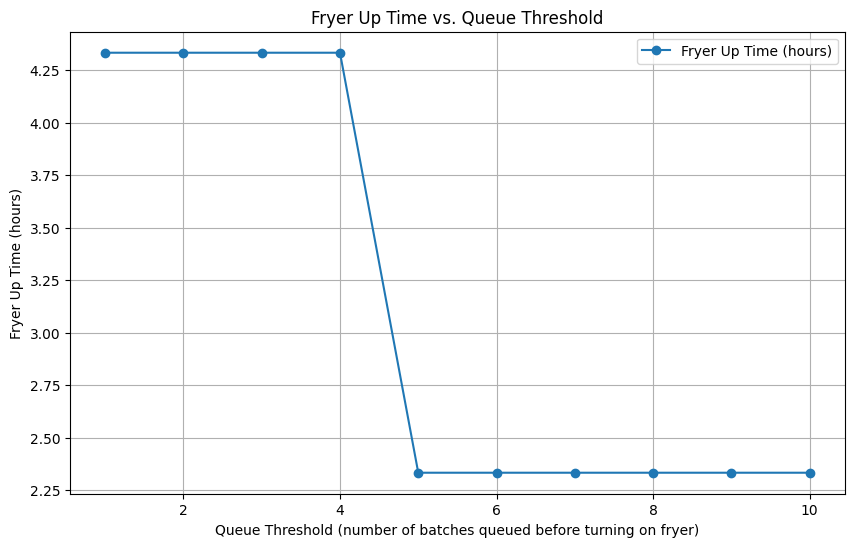

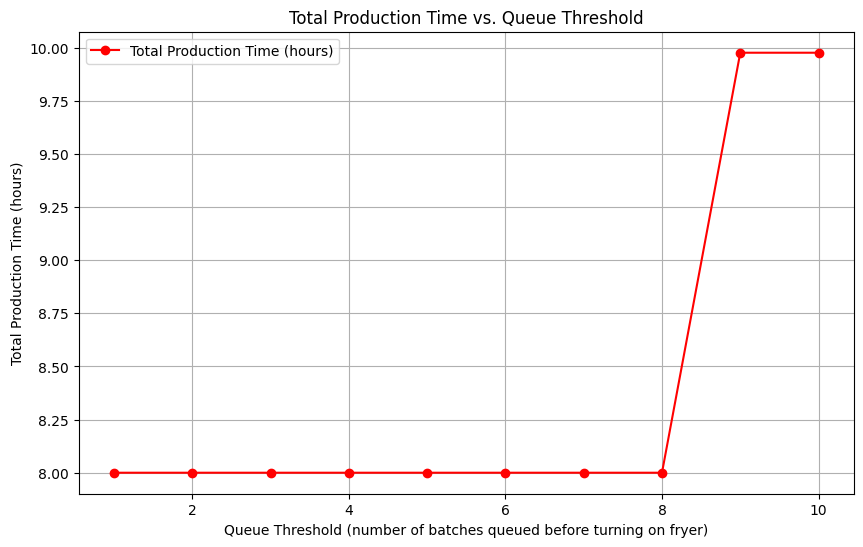

In [7]:
import simpy
import matplotlib.pyplot as plt

# -----------------------------
# Simulation Parameters
# -----------------------------
TOTAL_BATCHES = 10           # Fixed total number of batches to produce
BATCH_WEIGHT = 10            # kg per batch
COATING_MACHINE_CAPACITY = 10  # (each machine handles 10 kg, i.e. one batch)
FRYER_CAPACITY = 10          # kg per fryer load (one batch at a time)
SPICER_CAPACITY = 10         # kg per spicer machine (one batch at a time)

# Processing Times (in hours)
COATING_TIME = 2.0          # time per batch in coating (each machine)
NUM_COATING_MACHINES = 4     # 4 parallel coating machines
FRYER_HEATING_TIME = 1.0     # fixed heater warm-up time for each fryer cycle
FRYING_TIME = 8.0 / 60       # frying time per batch (8 minutes)
DEOILING_TIME = 15.0 / 60    # deoiling time per batch (15 minutes)
SPICING_TIME = 10.0 / 60     # spicing time per batch (10 minutes)
PACKAGING_TIME = 10.0 / 60   # packaging time per batch (10 minutes)

# -----------------------------
# Metrics Container
# -----------------------------
class Metrics:
    def __init__(self):
        self.fryer_on_time = 0.0     # Total time the fryer is active (includes heating delay for each cycle)
        self.batches_fried = 0       # Number of batches processed by the fryer
        self.total_production_time = 0.0  # Time when all batches finish post-frying processing

# -----------------------------
# Coating Process
# -----------------------------
def coating_process(env, machine_id, frying_queue, produced_counter, total_batches):
    """
    Each coating machine produces one batch (10 kg) every COATING_TIME hours.
    They run concurrently until the predetermined total is reached.
    """
    batch_id = 0
    while produced_counter[0] < total_batches:
        yield env.timeout(COATING_TIME)
        # Check again in case the total has been reached
        if produced_counter[0] < total_batches:
            batch_id += 1
            produced_counter[0] += 1
            batch = {
                'id': f"C{machine_id}-{batch_id}",
                'weight': BATCH_WEIGHT,
                'coating_time': env.now
            }
            frying_queue.put(batch)
            print(f"Time {env.now:.2f}: Batch {batch['id']} finished coating and queued for frying.")

# -----------------------------
# Fryer Process (Threshold-Driven)
# -----------------------------
def fryer_process(env, frying_queue, produced_counter, metrics, threshold, total_batches,
                  deoiling_resource, spicing_resource, packaging_resource):
    """
    The fryer checks the queue and starts a cycle when:
      - The queue length is at least 'threshold', OR
      - All batches have been produced (produced_counter == total_batches) and there is at least one batch waiting.
    
    Each cycle:
      - Incurs a fixed heating delay (FRYER_HEATING_TIME)
      - Processes all batches in the queue (each taking FRYING_TIME)
    """
    while metrics.batches_fried < total_batches:
        # Check if we should start a cycle:
        if (len(frying_queue.items) >= threshold) or (produced_counter[0] == total_batches and len(frying_queue.items) > 0):
            cycle_start = env.now
            print(f"Time {env.now:.2f}: Fryer turning on (starting heating). Queue size: {len(frying_queue.items)}")
            yield env.timeout(FRYER_HEATING_TIME)  # Heating delay
            cycle_fryer_time = FRYER_HEATING_TIME

            # Process batches until the queue empties.
            while len(frying_queue.items) > 0:
                batch = yield frying_queue.get()
                print(f"Time {env.now:.2f}: Frying batch {batch['id']} (weight: {batch['weight']} kg).")
                yield env.timeout(FRYING_TIME)
                cycle_fryer_time += FRYING_TIME
                metrics.batches_fried += 1
                # Launch post-frying process (concurrent)
                env.process(post_frying_process(env, batch, deoiling_resource, spicing_resource, packaging_resource))
            metrics.fryer_on_time += cycle_fryer_time
            print(f"Time {env.now:.2f}: Fryer cycle complete. Cycle time: {cycle_fryer_time:.2f} hours.")
        else:
            yield env.timeout(0.01)  # Check frequently

# -----------------------------
# Post-Frying Process
# -----------------------------
def post_frying_process(env, batch, deoiling_resource, spicing_resource, packaging_resource):
    """
    Processes a batch sequentially through:
      - Deoiling, then
      - Spicing, then
      - Packaging.
    Each step uses a dedicated resource (capacity 1).
    """
    with deoiling_resource.request() as req:
        yield req
        print(f"Time {env.now:.2f}: Batch {batch['id']} starting deoiling.")
        yield env.timeout(DEOILING_TIME)
        
    with spicing_resource.request() as req:
        yield req
        print(f"Time {env.now:.2f}: Batch {batch['id']} starting spicing.")
        yield env.timeout(SPICING_TIME)
        
    with packaging_resource.request() as req:
        yield req
        print(f"Time {env.now:.2f}: Batch {batch['id']} starting packaging.")
        yield env.timeout(PACKAGING_TIME)
        
    print(f"Time {env.now:.2f}: Batch {batch['id']} completed post-frying processing.")

# -----------------------------
# Simulation Runner for a Given Threshold
# -----------------------------
def run_simulation(threshold, total_batches):
    env = simpy.Environment()
    frying_queue = simpy.Store(env)
    produced_counter = [0]  # Mutable counter for produced batches
    metrics = Metrics()
    
    # Create resources for post-frying processes.
    deoiling_resource = simpy.Resource(env, capacity=1)
    spicing_resource = simpy.Resource(env, capacity=1)
    packaging_resource = simpy.Resource(env, capacity=1)
    
    # Start coating processes (4 machines)
    for i in range(NUM_COATING_MACHINES):
        env.process(coating_process(env, i+1, frying_queue, produced_counter, total_batches))
    
    # Start the fryer process (it will run multiple cycles if needed)
    env.process(fryer_process(env, frying_queue, produced_counter, metrics, threshold, total_batches,
                              deoiling_resource, spicing_resource, packaging_resource))
    
    # Run the simulation until all processes (including post-frying) complete.
    env.run()
    metrics.total_production_time = env.now
    print(f"\n--- Simulation complete for threshold {threshold} ---")
    print(f"Total production time: {metrics.total_production_time:.2f} hours")
    print(f"Fryer on time: {metrics.fryer_on_time:.2f} hours")
    print(f"Total batches fried: {metrics.batches_fried}\n")
    return metrics

# -----------------------------
# Run Multiple Simulations & Plot Results
# -----------------------------
def run_multiple_simulations():
    # Test a range of threshold values from 1 up to TOTAL_BATCHES.
    thresholds = list(range(1, TOTAL_BATCHES + 1))
    fryer_on_times = []
    production_times = []
    
    for thresh in thresholds:
        print(f"\n=== Running simulation for queue threshold = {thresh} ===")
        metrics = run_simulation(thresh, TOTAL_BATCHES)
        fryer_on_times.append(metrics.fryer_on_time)
        production_times.append(metrics.total_production_time)
    
    # Plot Fryer Up Time vs. Queue Threshold
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, fryer_on_times, marker='o', label='Fryer Up Time (hours)')
    plt.xlabel("Queue Threshold (number of batches queued before turning on fryer)")
    plt.ylabel("Fryer Up Time (hours)")
    plt.title("Fryer Up Time vs. Queue Threshold")
    plt.grid(True)
    plt.legend()
    plt.show()
    
    # Plot Total Production Time vs. Queue Threshold
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, production_times, marker='o', color='red', label='Total Production Time (hours)')
    plt.xlabel("Queue Threshold (number of batches queued before turning on fryer)")
    plt.ylabel("Total Production Time (hours)")
    plt.title("Total Production Time vs. Queue Threshold")
    plt.grid(True)
    plt.legend()
    plt.show()

if __name__ == "__main__":
    run_multiple_simulations()
